In [1]:
from pyhmc import hmc
import autograd.numpy as np  # Thinly-wrapped numpy
import autograd.scipy as scipy
from autograd import grad    # The only autograd function you may ever need
from autograd import jacobian  
from autograd import elementwise_grad as egrad 
from scipy.special import gamma
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [2]:
def tanh(x,z):
    
    y = np.exp(-2.0*x*z)
    return (1.0 - y) / (1.0 + y)


def plano(x, param):
    
    
    return x[0]+2*x[1]+param

x = np.linspace(-7, 7, 200)

grad(plano)(np.array([0.4, 0.3]), 0.5)


array([1., 2.])

In [3]:
L = 20.0

def S(tau, theta):
    
    return theta[0]*np.exp(tau**2/theta[1])

def Lambda(n,L):
    return (n+1)*np.pi/(2*L)

def gamma_plus(i,j,L):
    
    return Lambda(i,L) + Lambda(j,L)

def gamma_minus(i,j,L):
    
    return Lambda(i,L) - Lambda(j,L)

# def psi(x,i,j,L):
    
#     if i==j:
        
#         return 1/(2*L)*(x+L) - np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L))
    
#     else:
        
#          return np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L))

        
def psi(x,i,j,L):
    
    if i==j:
        
        t1 = 1/(2*L)*x
        t2 = np.sin(gamma_plus(j,j,L)*(x+L) )/(2*L*gamma_plus(j,j,L)) - np.sin(gamma_plus(j,j,L)*(L) )/(2*L*gamma_plus(j,j,L))
        
        return t1 - t2
    
    else:
        
        t1 = np.sin(gamma_minus(i,j,L)*(x+L) )/(2*L*gamma_minus(i,j,L)) - np.sin(gamma_minus(i,j,L)*(L) )/(2*L*gamma_minus(i,j,L))
        t2 = np.sin(gamma_plus(i,j,L)*(x+L) )/(2*L*gamma_plus(i,j,L)) - np.sin(gamma_plus(i,j,L)*(L) )/(2*L*gamma_plus(i,j,L))

        return t1 - t2

        
def Psi(x,L, N):

    MPsi = np.zeros((N,N))
    for i in range(0,N):
        for j in range(0,N):
            MPsi[i,j] = psi(x,i,j,L)
            
    return MPsi
        
        
def g(x, f_0, alpha):
    
    MPsi = Psi(x,L, len(alpha))
    
    return f_0 + alpha.T@ (MPsi@alpha)


def f(x, f_0, alpha):
    
    N = len(alpha)
    
    #MPsi = Psi(x,L, N)
    
    quad = 0
    
    
    for i in range(0,N):
        for j in range(0,N):
            quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
    return f_0 + quad#alpha.T@ (MPsi@alpha)


def f(x, f_0, alpha, MPsi):
    
#     N = len(alpha)
    
    #MPsi = Psi(x,L, N)
    
#     quad = 0
    
    
#     for i in range(0,N):
#         for j in range(0,N):
#             quad = psi(x,i,j,L) * alpha[i] * alpha[j]
    
    
    return f_0 + alpha.T@ (MPsi@alpha)


    
def Pre_Mat(N, theta):
    
    u = np.zeros(N)
    
    for i in range(N):
        
        u[i] = 1/S(Lambda(i, L), theta)
        
    return np.diag(u)


def ker(x,y):
    
    return 1.0 +x*y*0




In [4]:
def log_likelihood(f_0, alpha, Y, X, C, mu, MPsi):
    
#     f_0 = beta[0]
#     alpha = beta[1:]
  
    l = 0
    
    for i in range(len(Y)):
        

        sigma2 = f(C[i], f_0, alpha, MPsi[i])
        
                
        l += -( mu - Y[i]  )**2/sigma2 - np.log(sigma2)
    
    
    return l

def logp_f_0(log_f, theta1, theta2):
    
    f_0 = np.exp(log_f)
    
    #return - (f_0-theta1)**2/theta2
    
    
    return  (theta1 -1)*log_f - theta2*np.exp(log_f) #+ theta1*np.log(theta2) - np.log(gamma(theta1))

def logp_alpha(alpha, theta):
    
    
    l = 0
    
    for i in range(len(alpha)):
        
        if S(Lambda(i,L), theta) <= 0.0:
            print('Problema en S')
        
        l += -0.5*(alpha[i]**2/ S(Lambda(i,L), theta )) - 0.5*np.log(S(Lambda(i,L),theta ))
    
    return l


def logp_mu(mu):
    
    return -0.5*mu**2/1 - 0.5*np.log(1)


def log_p(beta, mu, theta1, theta2, theta, Y,X, C, MPsi):
    
    f_0 = np.exp(beta[0]) 
    alpha = beta[1:]
    
    return logp_mu(mu) + logp_alpha(alpha, theta)+ logp_f_0(beta[0], theta1, theta2)+log_likelihood(f_0, alpha, Y, X, C, mu, MPsi)




In [5]:
#Gaussian process in the param

# def log_likelihood_GP(f_0, alpha, Y, K, C):
    
#     f_0 = beta[0]
#     alpha = beta[1:]
  

    
#     D = np.zeros(len(C))
    

#     for i in range(len(C)):
#         #we add a little noise to the diagonal to ensure PD of the matrix
# #         f(C[i], f_0, alpha)
# #         print(A[i,i], i)
#         e_i = np.zeros(len(C))
#         e_i[i] = 1.0
#         D += (f(C[i], f_0, alpha) + 0.0001)*e_i
#         A[i,i] += 0.0001
    
#     A = K + np.eye(len(C))*D
    
    
    
#     x = np.linalg.solve(A, Y)
    
    
#     return -0.5*np.dot(Y,x) - 0.5*np.log(np.linalg.det(A))
    


# def log_p_GP(beta, theta1, theta2, theta, Y,K, C):
    
#     f_0 = beta[0] 
#     alpha = beta[1:]
    
#     return logp_alpha(alpha, theta)+ logp_f_0(f_0, theta1, theta2)+log_likelihood_GP(f_0, alpha, Y, K, C)




In [6]:
# def g(c):
#     return np.array([c ** 0, c, c ** 2]).squeeze()

def g(c, w_0=0.5, w_1=7, w_2 = 10):
    return w_0 ** 2 + (w_1 ** 2) * c + w_2 *c**2

w_0 = 1.1
w_1 = 2
w_2 = 0.1
w = np.array([w_0, w_1, w_2]).squeeze()

num_samples = 20
mu = 3


X = np.linspace(0,1, num_samples)

C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = 10), np.random.uniform(2., 5., size = num_samples - 10) ) )


sigma2 = g(C, *w)


eps = []

for sigma in sigma2:
    assert sigma > 0, f'Sigma is {sigma}'
    noise = norm(scale=sigma ** 0.5).rvs(1)
    eps.append(noise)

eps = np.array(eps).squeeze()
assert eps.shape == (num_samples,)
Y = mu + eps

2.4354652331493685


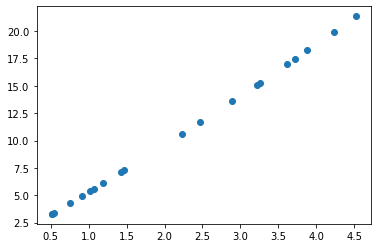

In [7]:
print(np.mean(Y))
plt.scatter(C, sigma2)


In [10]:

theta1 = 0.0
theta2 = 3.
theta = np.array([3., 1.0])



K = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i,j] = ker(X[i], X[j])
beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2]) +10

N = len(beta_0) - 2


MPsi = []

for i in range(len(C)):
    
    MPsi.append(Psi(C[i],L, N))


In [9]:
#Hyper Parameters
import time

t0 = time.time()

#Hyper mean



# Kernel of the GP



def log_Evidence(theta, beta_0):
    
    to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess, method='Newton-CG').x
    
   
    A = Hess(beta_0)

    det = np.linalg.det(Hess*2*np.pi)
    
    return -to_opti(beta) + 0.5*np.log(det)



def maximum_posterior(beta_0):
    
    to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


    nab_p = lambda beta: grad(to_opti)(beta)
    
    Hess = lambda beta: jacobian(nab_p)(beta)

    beta = minimize(to_opti, beta_0 , jac=nab_p, hess = Hess,method='Newton-CG').x
    
    
#     det = np.linalg.det(Hess*2*np.pi)
    
    return beta







# log_p(beta_0, 0.4, 0.4, 0.5, np.array([0.4, 0.4]), Y, X, C)

beta_0 = maximum_posterior(beta_0)

# print(beta_0)

# to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


# nab_p = lambda beta: grad(to_opti)(beta)


# Hess = lambda beta: jacobian(nab_p)(beta)

# minimize(to_opti, beta_0, jac=nab_p, hess = Hess, method='Newton-CG')



minimize(to_opti, xbeta_0 , jac=nab_p, hess = Hess,method='Newton-CG')
    


# print(np.shape(MPsi[0]))
# print(to_opti(beta_0))

# nab_f = lambda x: grad(f)(0.4, x[0], x[1:])

# theta = np.array([1.4, 2.0])

# # grad_evidence = grad(log_Evidence)(theta, beta_0)

# t0 = time.time()

# print(log_Evidence(theta, beta_0))



# print(time.time() - t0)

# print(beta)


NameError: name 'MPsi' is not defined

In [64]:
to_sample = lambda beta: log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


grad_p = lambda beta: grad(to_sample)(beta)

def logprob(beta):
    
    return to_sample(beta), grad_p(beta) 


samples = hmc(logprob, x0=beta, n_samples=1000, epsilon = 0.1)

print(samples[1])

print(samples[50])

[ 2.96105349e+00 -3.54280716e+04  2.40666193e+00 -6.05602575e-01
 -1.83411887e+00  9.72518792e-01  2.54055427e+00 -1.40421048e+00
 -2.33084384e+00  1.34335210e+00]
[ 2.59211080e+00 -3.54288879e+04  2.17301229e+00 -1.29143602e+00
 -2.49492087e+00  1.46607518e+00  2.12631352e+00 -1.98697528e+00
 -2.14247488e+00  4.15312725e-01]


In [65]:
aproximation_sampler = np.zeros( (len(C),1000) )


for i in range(num_samples):
    
    for j in range(1000):
    
        aproximation_sampler[i,j] = f(C[i], np.exp(samples[j][1]), samples[j][2:], MPsi[i])
        
aproximate_mean = np.mean(aproximation_sampler, axis = 1)

np.shape(aproximate_mean)

(20,)

[Text(0.5, 0, 'c score'),
 Text(0, 0.5, '$\\sigma^2$'),
 Text(0.5, 1.0, 'Reconstruction of $g(c)$')]

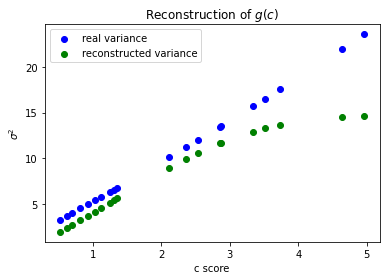

In [66]:
fig, ax = plt.subplots()

ax.scatter(C, sigma2, c='b', label = 'real variance')
ax.scatter(C, aproximate_mean, c = 'g', label = 'reconstructed variance')
ax.legend()


ax.set(xlabel='c score', ylabel='$\sigma^2$', title='Reconstruction of $g(c)$')




In [67]:
aproximation = np.zeros(len(C))

Pres = jacobian(nab_p)(beta_0)


Sigma = np.linalg.inv(Pres[2:, 2:])




for i in range(num_samples):
    
    aproximation[i] = f(C[i], np.exp(beta[1]), beta[2:], MPsi[i]) + np.sum(Sigma*MPsi[i])
    
print(aproximation)

[ 6.17888684  2.72092531  7.51120854  5.02720801  3.68640927  4.40192767
  6.91393665  5.66054092  7.24388642  3.31828984 13.78053285 15.2148628
 17.30848289 19.58901788 11.74951435 16.80698161 19.28998852 12.97064107
 17.86016745 15.15260745]


[Text(0.5, 0, 'c score'),
 Text(0, 0.5, '$\\sigma^2$'),
 Text(0.5, 1.0, 'Reconstruction of $g(c)$')]

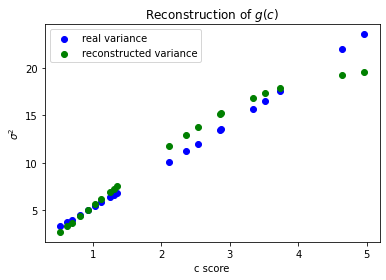

In [68]:
fig, ax = plt.subplots()

ax.scatter(C, sigma2, c='b', label = 'real variance')
ax.scatter(C, aproximation, c = 'g', label = 'reconstructed variance')
ax.legend()


ax.set(xlabel='c score', ylabel='$\sigma^2$', title='Reconstruction of $g(c)$')



In [396]:
print(beta)

[ 2.90943223e+00 -8.57921984e+07 -3.06143528e+00 -4.52207025e+00
 -1.03031532e+01  2.83077645e+00  2.67340218e+00 -1.51842223e+01
  3.45105871e+00  1.12805370e+01]


In [481]:
print((np.mean(Y) - 3)/3)
print((beta[0] -3)/3)
print((np.mean(Y[:10]) -3 )/3)

-0.11779093747585619
-0.21851796214111566
-0.13195548093876797


In [365]:
def second_aprox(Y, sigma2):
    
    pres = 1/sigma2
    
    tot = np.sum(pres)
    
    return 1/tot * np.dot(Y,pres)

second_aprox(Y, aproximation)

2.998609029097172

In [14]:
#Hyper Parameters

# theta1 = 0.0
# theta2 = 3.
# theta = np.array([20., 1.0])



# # Kernel of the GP

# K = np.zeros((num_samples, num_samples))

# for i in range(num_samples):
#     for j in range(num_samples):
#         K[i,j] = ker(X[i], X[j])


# beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2]) +10

# log_p_GP(beta_0, 0.4, 0.4, 0.5, np.array([0.4, 0.4]), Y, X, C)

# to_opti_GP = lambda beta: -log_p_GP(beta[1:], beta[0], theta1, theta2, theta, Y, K, C)


# nab_p_GP = lambda beta: grad(to_opti_GP)(beta)
# Hessian_p_GP = lambda beta: jacobian(nab_p_GP)(beta)

# na_p_GP(beta_0)

TypeError: log_p_GP() takes 7 positional arguments but 8 were given

In [455]:

def g(c, w_0=0.5, w_1=7, w_2 = 10):
    return w_0 ** 2 + (w_1 ** 2) * c + w_2 *c**2

num_samples = 20
mu = 3

w_0 = 1.1
w_1 = 2
w_2 = 0.1
w = np.array([w_0, w_1, w_2]).squeeze()

X = np.linspace(0,1, num_samples)

exp_mean = np.zeros((5,15))
alg_mean = np.zeros((5,15))
good_mean = np.zeros((5,15))
second_alg = np.zeros((5,15))



K = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        K[i,j] = ker(X[i], X[j])


beta_0 = np.array([0.4, 0.4, 1.0, 0.4, 0.4, 0.4, 0.5, 0.6, 1, 2]) +10

alpha_alg = np.zeros((5, 15, len(beta_0) - 1))




for i in range(5):
    
    for j in range(15):
    
        good_points = 4*(i+1)



        C = np.concatenate(  (np.random.uniform(0.5, 1.5, size = good_points), np.random.uniform(2., 6., size = num_samples - good_points) ) )

        sigma2 = g(C, *w)

        eps = []

        for sigma in sigma2:
            assert sigma > 0, f'Sigma is {sigma}'
            noise = norm(scale=sigma ** 0.5).rvs(1)
            eps.append(noise)

        eps = np.array(eps).squeeze()
        assert eps.shape == (num_samples,)
        Y = mu + eps
        
        exp_mean[i, j] = np.mean(Y) 
        good_mean[i,j] = np.mean(Y[0:good_points])
        
        
        MPsi = []

        for k in range(len(C)):
    
            MPsi.append(Psi(C[k],L, N))
        
        to_opti = lambda beta: -log_p(beta[1:], beta[0], theta1, theta2, theta, Y, X, C, MPsi)


        nab_p = lambda beta: grad(to_opti)(beta)
        
        beta = minimize(to_opti, beta_0 , jac=nab_p, method='Newton-CG').x
        
        aproximation = np.zeros(len(C))


        for l in range(num_samples):
    
            aproximation[l] = f(C[l], np.exp(beta[1]), beta[2:], MPsi[l])
    
        
        
        alg_mean[i,j] = beta[0]
        
        alpha_alg[i,j,:] = beta[1:]
        
        second_alg[i,j] = second_aprox(Y, aproximation)


[Text(0.5, 0, 'Percentage of good points'),
 Text(0, 0.5, '$E[| \\mu - \\hat{\\mu}| ]/\\mu$'),
 Text(0.5, 1.0, 'Error in estimated $\\mu$')]

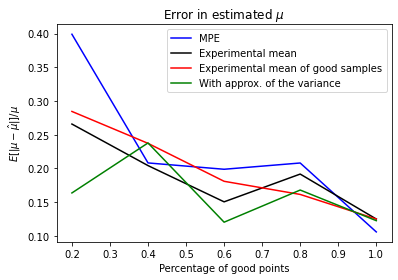

In [500]:
error_alg_20 = np.mean(np.absolute(alg_mean - mu)/mu, axis = 1)
error_exp_20 = np.mean(np.absolute(exp_mean - mu)/mu, axis = 1)
error_good_20 = np.mean(np.absolute(good_mean - mu)/mu, axis = 1)
error_second_20 = np.mean(np.absolute(second_alg - mu)/mu, axis = 1)


percentage = np.array([4, 8, 12, 16,20])/20 

fig, ax = plt.subplots()
ax.plot(percentage, error_alg_20, c = 'b', label = 'MPE')
ax.plot(percentage, error_exp_20, c = 'k', label = 'Experimental mean')
ax.plot(percentage, error_good_20, c = 'r', label = 'Experimental mean of good samples')
ax.plot(percentage, error_second_20, c = 'g', label = 'With approx. of the variance')

ax.legend()
ax.set(xlabel='Percentage of good points', ylabel='$E[| \mu - \hat{\mu}| ]/\mu$',
       title='Error in estimated $\mu$')


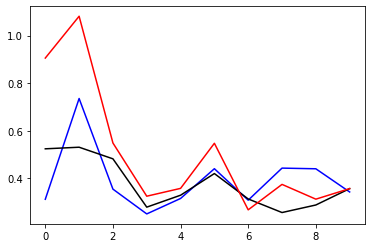

In [446]:
# plt.plot(error_alg_40, c = 'b')
# plt.plot(error_exp_40, c = 'k')
# plt.plot(error_good_40, c = 'r')